# Class 07
## ML Models: Decision Trees

We will cover a new type of machine learning algorithm in this class: decision trees. We will also talk about ensemble methods and how we can use them to improve the performance of our machine learner.

### Classification Decision Trees

We'll start by using a decision tree classifier. We'll use the same set of data as we used in Class 06. Again, that will allow us to compare the algorithm head-to-head with the other classifiers we've used previously. A **decision tree** works by splitting the data into pieces while trying to maximize the uniformity of each piece. Although we won't dive deeply into how the algorithm works, [you can read a great tutorial here](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/).

For example we start with a group of 10 people, half who identify as male and half as female. The most uniform split will be to divide the group into two sub-groups known as nodes. We can cleanly split the group so that each sub-group is uniformly populated. The tree builds a set of decision nodes to split the group so as to end up with the best set of rules to predict the output labels.

The tree will continue to split until it reaches a point where it can't split the data anymore. These end points are called **leaf nodes**. The number of data points allowed to be in a leaf node is one of the hyperparameters we have to tune. Going back to our example, if we set the minimum size of the leaf node to 5 people, the decision tree will end after doing a single split. However, if we let the leaf nodes be smaller, it may split up the sub-groups by age, height, or by other features.

This will make more sense as we try it out, so let's get started.

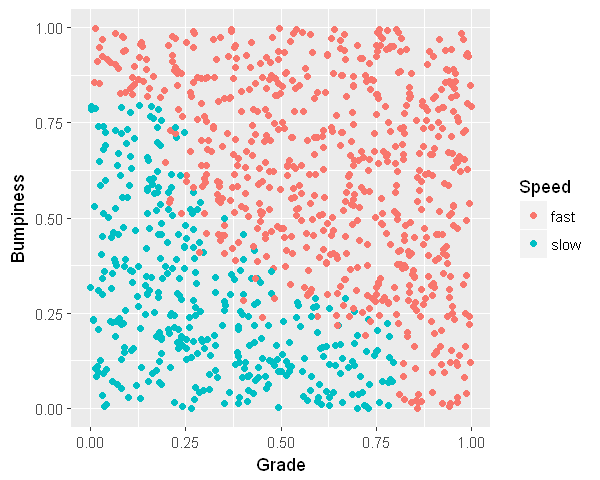

In [1]:
library(ggplot2)
speeddf <- read.csv("../Class04/Class04_speed_data.csv")

options(repr.plot.width=5, repr.plot.height=4)
ggplot() + geom_point(aes(Grade,Bumpiness, col=Speed), data=speeddf)+ coord_fixed()

Because we are going to use the `caret` library, we can take advantage of a couple of other utilities that come with that library. One of them is the `createDataPartition()` function which will do the random test/train split calculations for us.

Note that we've use the `set.seed()` function again to set the random seed before we start. This will give us the same results every time we run this block.

The model we are using for our `train()` function is called `rpart2`, a type of decision tree. We will start by using the default parameters and see what we get.

Loading required package: lattice
Warning message:
"package 'pracma' was built under R version 3.3.3"

          Reference
Prediction fast slow
      fast  120    4
      slow    7   68


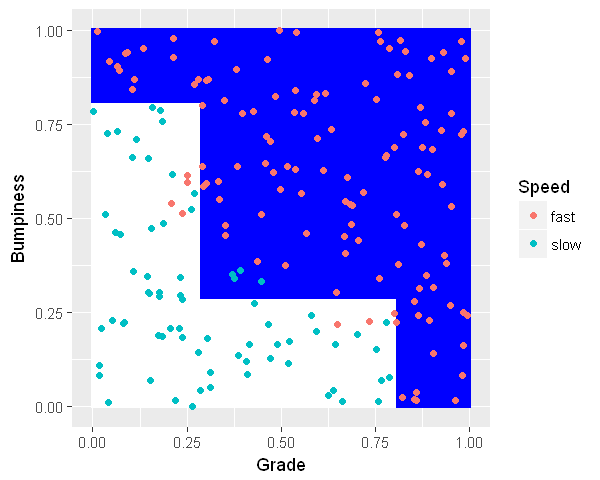

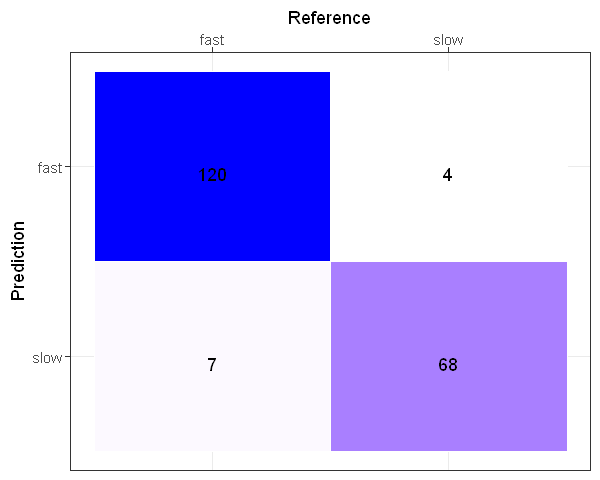

In [2]:
library(caret)
library(rpart)
library(pracma)

set.seed(3033)
intrain <- createDataPartition(y = speeddf$Speed, p= 0.8, list = FALSE)
train <- speeddf[intrain,]
test <- speeddf[-intrain,]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh
x_min <- 0.0; x_max <- 1.0 # Mesh x size
y_min <- 0.0; y_max <- 1.0  # Mesh y size
h <- .01  # step size in the mesh
mesh<-meshgrid(seq(x_min,x_max,h),seq(y_min,y_max,h))
meshdf <- data.frame(Grade=c(mesh$X),Bumpiness=c(mesh$Y))

dtree_fit <- train(Speed ~., data = train, method ="rpart",
      control = rpart.control(minsplit = 10),
                  trControl=trainControl(method="none"),
                       tuneGrid=data.frame(cp=0.1))

meshdf$Prediction <- predict(dtree_fit,meshdf)
meshdf$col <- ifelse(meshdf$Prediction == 'fast', 'blue', 'white')

p <- ggplot(meshdf) +
 geom_rect(mapping = aes(xmin=Grade-h/2, xmax=Grade+h/2, ymin=Bumpiness-h/2, ymax=Bumpiness+h/2),fill = meshdf$col) + 
 coord_fixed()
p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)


pred <- predict(dtree_fit, test)
cm<-confusionMatrix(pred,test$Speed)
print(cm$table)

Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

In [3]:
cm$byClass

Sensitivity          Specificity       Pos Pred Value 
           0.9448819            0.9444444            0.9677419 
      Neg Pred Value            Precision               Recall 
           0.9066667            0.9677419            0.9448819 
                  F1           Prevalence       Detection Rate 
           0.9561753            0.6381910            0.6030151 
Detection Prevalence    Balanced Accuracy 
           0.6231156            0.9446632

In [4]:
cm$overall["Accuracy"]

Accuracy 
0.9447236

Take a look at the decision boundary for this classifier: it consists of straight lines that cut the data horizontally and vertically. The model is trying to split the data into groups and, since our inputs are continuous variables, it cuts them at a threshold to do that.

The accuracy of the fit is pretty good, even for our very simple decision boundary! What happens if we tune the parameters and look for a better solution? There are a couple of parameters for this model:
* `minsplit` which is the minimum number of observations that must exist in a node in order for a split to be attempted. 
* `cp` which is the complexity parameter - the larger this value is, the simpler the model will be. 
Let's explore what happens if we change these.

          Reference
Prediction fast slow
      fast  121    1
      slow    6   71


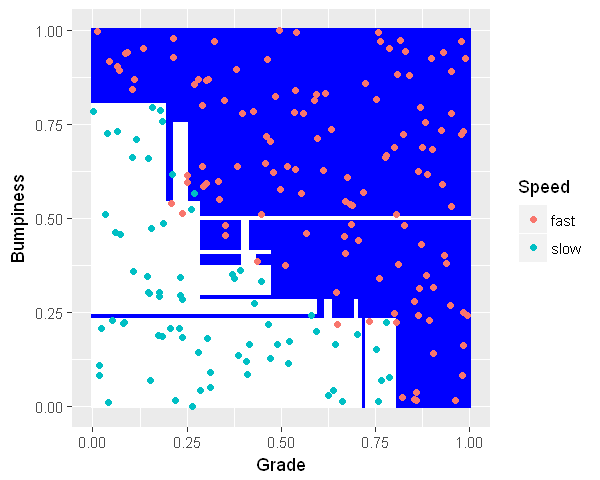

[1] "Accuracy: 0.964824120603015"


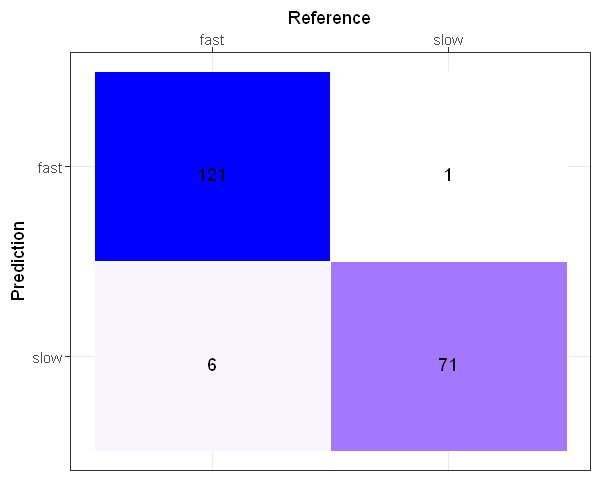

In [5]:
set.seed(3033)
intrain <- createDataPartition(y = speeddf$Speed, p= 0.8, list = FALSE)
train <- speeddf[intrain,]
test <- speeddf[-intrain,]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh
dtree_fit <- train(Speed ~., data = train, method ="rpart",
      control = rpart.control(minsplit = 2),
                  trControl=trainControl(method="none"),
                       tuneGrid=data.frame(cp=0.001))
                   
                   
meshdf$Prediction <- predict(dtree_fit,meshdf)
meshdf$col <- ifelse(meshdf$Prediction == 'fast', 'blue', 'white')

p <- ggplot(meshdf) +
 geom_rect(mapping = aes(xmin=Grade-h/2, xmax=Grade+h/2, ymin=Bumpiness-h/2, ymax=Bumpiness+h/2),fill = meshdf$col) + 
 coord_fixed()
p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)


pred <- predict(dtree_fit, test)
cm<-confusionMatrix(pred,test$Speed)
print(cm$table)

Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

print(paste("Accuracy:",cm$overall["Accuracy"]))

Take a look at the decision boundary for this classifier: it is all over the place! The tree tries to account for every point and so it creates braches where there shouldn't be branches. We have a classic case of overfitting!  It is time to tune the hyperparameters to see if we can do better. Let's start by tuning the minimum number of samples in the leaf nodes of the tree.

          Reference
Prediction fast slow
      fast  120    0
      slow    7   72


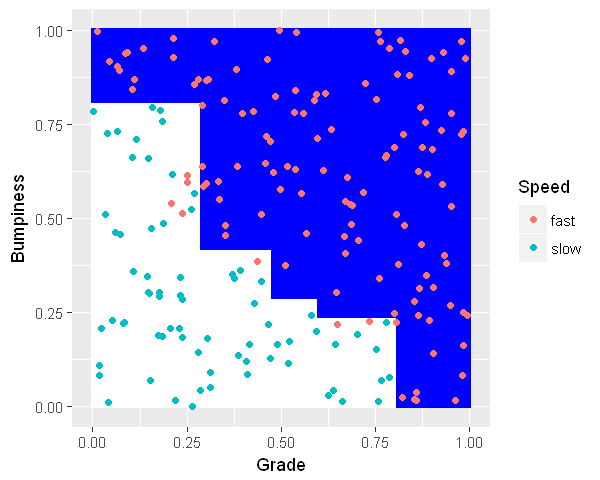

[1] "Accuracy: 0.964824120603015"


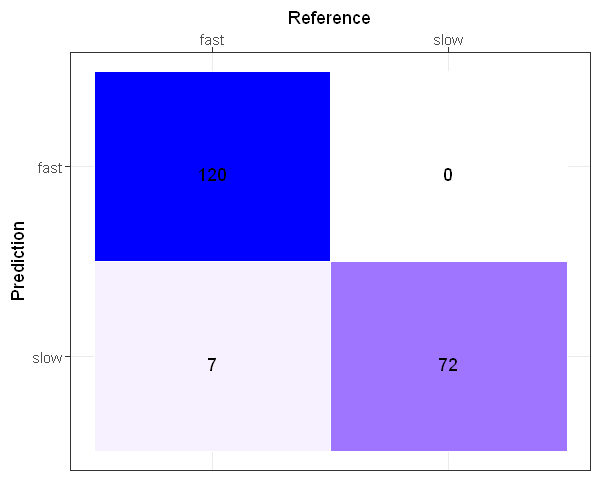

In [6]:
set.seed(3033)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh
dtree_fit <- train(Speed ~., data = train, method ="rpart",
      control = rpart.control(minsplit = 5),
                  trControl=trainControl(method="none"),
                       tuneGrid=data.frame(cp=0.01))
                   
                   
meshdf$Prediction <- predict(dtree_fit,meshdf)
meshdf$col <- ifelse(meshdf$Prediction == 'fast', 'blue', 'white')

p <- ggplot(meshdf) +
 geom_rect(mapping = aes(xmin=Grade-h/2, xmax=Grade+h/2, ymin=Bumpiness-h/2, ymax=Bumpiness+h/2),fill = meshdf$col) + 
 coord_fixed()
p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)


pred <- predict(dtree_fit, test)
cm<-confusionMatrix(pred,test$Speed)
print(cm$table)

Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

print(paste("Accuracy:",cm$overall["Accuracy"]))

So our decision boundary is cleaned up significantly *and* we got the same accuracy! Note that all of the boundaries are straight lines- that is because the decision tree is choosing cutoff values of "Grade" and "Bumpiness" to split the dataset along those lines. Overall this isn't too bad.

### Ensemble Methods

The decision tree did a reasonable job of modeling our data but we only used *one* tree and *one* set of random values. What if we could do this many times and average the results. There are tools to do that! One of the strategies that ensemble methods will use is to scramble which of the training features it uses for each trial run. Let's take a quick look at that method, called a "bootstrap" sample.

We will start with 100 data points in our training sample. The ensemble model will break this up into 10 chunks of 10 data points each (each chunk labeled A-J). For the first model it takes chunks A-I and trains on them, then validates that model with chunk J. The next model will take chunks A-H and J, leaving chunk I for validation. It repeats this as many times as it needs. Thus the ensemble is doing training and validation all on the same set of data!

#### Data Snooping Warning

> Although the ensemble is doing its own validation, that doesn't mean you can train with all of your data. You still need to keep the test data locked away and not used for training. This means we can compare the ensemble model to the other models without cheating ourselves.

We'll try out the simplest version of this first, called the `RandomForestClassifier`.

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin



          Reference
Prediction fast slow
      fast  120    2
      slow    7   70


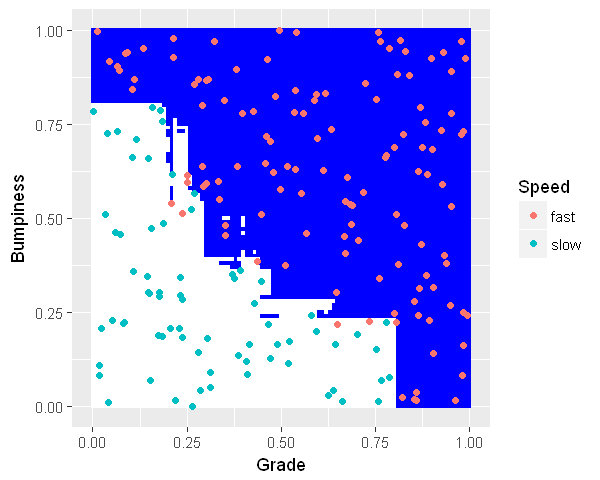

[1] "Accuracy: 0.954773869346734"


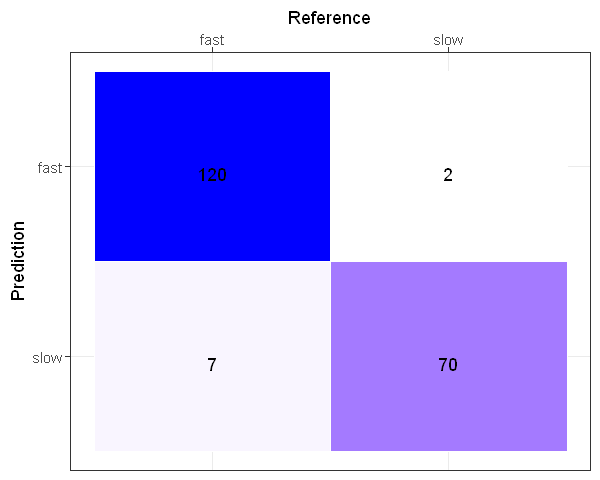

In [7]:
library(randomForest)
#Fit the random forest model
set.seed(3033)
rf_fit <- randomForest(Speed ~., data = train,
                      importance=FALSE, 
                      ntree=200)
                   
meshdf$Prediction <- predict(rf_fit,meshdf)
meshdf$col <- ifelse(meshdf$Prediction == 'fast', 'blue', 'white')

p <- ggplot(meshdf) +
 geom_rect(mapping = aes(xmin=Grade-h/2, xmax=Grade+h/2, ymin=Bumpiness-h/2, ymax=Bumpiness+h/2),fill = meshdf$col) + 
 coord_fixed()
p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)


pred <- predict(rf_fit, test)
cm<-confusionMatrix(pred,test$Speed)
print(cm$table)

Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

print(paste("Accuracy:",cm$overall["Accuracy"]))

We see that the ensemble does a reasonable job- perhaps not better, in this case, than the decision tree by itself. However, there is something else that we get out of using the ensemble: it will tell us the relative importance of the different features it used in making the decision boundary. The list of feature importances are given in terms of percentage importance of each feature. This can be helpful in deciding which features to use as inputs to the model. If the ensemble says that a feature is not very important, you may be able to drop it and simplify your model.

Let's look at our feature importances:

In [8]:
print(importance(rf_fit,type = 2)) 

          MeanDecreaseGini
Grade             179.6654
Bumpiness         190.0618


Both features (Grade and Bumpiness) have just about the same importance in our model (about 50% each). That isn't too surprising since we faked the data to begin with...

Let's try some other ensemble methods to see how they work.

### AdaBoost Classifier

This is another ensemble classifier that iteratively learns using a series of weights.

Warning message:
"package 'fastAdaboost' was built under R version 3.3.3"

          Reference
Prediction fast slow
      fast  120    3
      slow    7   69


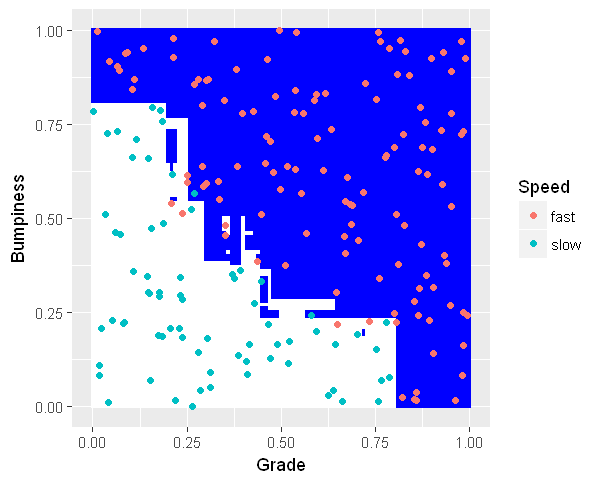

[1] "Accuracy: 0.949748743718593"


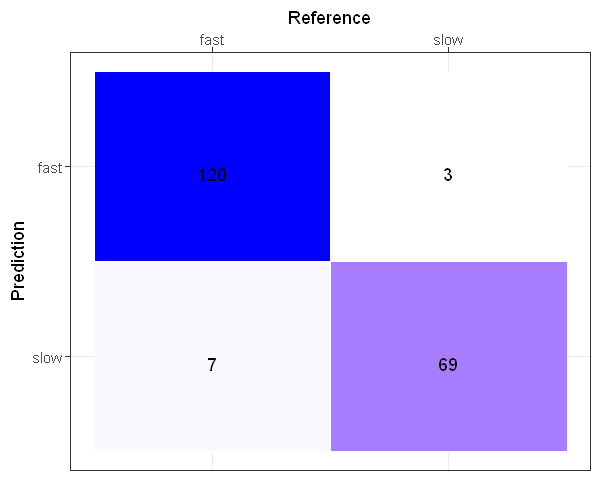

In [9]:
library(fastAdaboost)
set.seed(3033)
ab_fit<-adaboost(Speed ~., data = train, nIter=20)
meshdf$Prediction <- predict(ab_fit,meshdf)$class 

meshdf$col <- ifelse(meshdf$Prediction == 'fast', 'blue', 'white')

p <- ggplot(meshdf) +
 geom_rect(mapping = aes(xmin=Grade-h/2, xmax=Grade+h/2, ymin=Bumpiness-h/2, ymax=Bumpiness+h/2),fill = meshdf$col) + 
 coord_fixed()
p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)


pred <- predict(ab_fit, test)$class
cm<-confusionMatrix(pred,test$Speed)
print(cm$table)

Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

print(paste("Accuracy:",cm$overall["Accuracy"]))

### XGBoost

This last ensemble method requires a little different preparation. It doesn't take a formula, but rather a data matrix (of all but our last column).

In [10]:
#install.packages("xgboost",repos="http://cran.us.r-project.org")
library(xgboost)
set.seed(3033)

xgb_fit<-xgboost(data = data.matrix(train[,1:2]), 
 label = as.numeric(train$Speed)-1, 
 eta = 0.1,
 max_depth =5, 
 nround=25, 
 seed = 1,
 eval_metric = "merror",
 objective = "multi:softprob",
 num_class = 2
)

Warning message:
"package 'xgboost' was built under R version 3.3.3"

[1]	train-merror:0.024969 
[2]	train-merror:0.023720 
[3]	train-merror:0.021223 
[4]	train-merror:0.022472 
[5]	train-merror:0.022472 
[6]	train-merror:0.019975 
[7]	train-merror:0.019975 
[8]	train-merror:0.019975 
[9]	train-merror:0.019975 
[10]	train-merror:0.019975 
[11]	train-merror:0.019975 
[12]	train-merror:0.019975 
[13]	train-merror:0.018727 
[14]	train-merror:0.018727 
[15]	train-merror:0.018727 
[16]	train-merror:0.018727 
[17]	train-merror:0.018727 
[18]	train-merror:0.016230 
[19]	train-merror:0.016230 
[20]	train-merror:0.016230 
[21]	train-merror:0.016230 
[22]	train-merror:0.016230 
[23]	train-merror:0.016230 
[24]	train-merror:0.017478 
[25]	train-merror:0.016230 


          Reference
Prediction fast slow
      fast  120    2
      slow    7   70


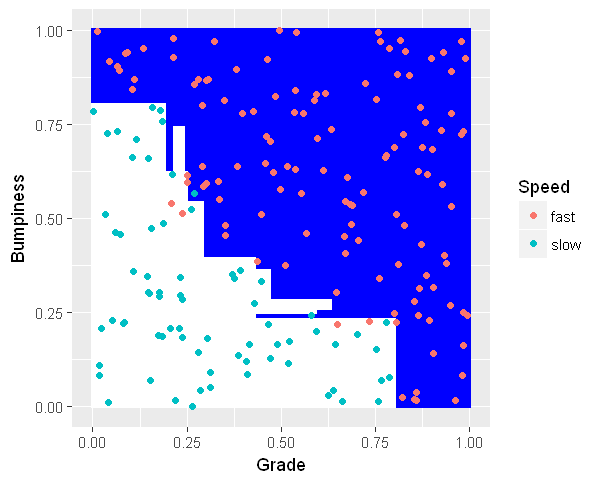

[1] "Accuracy: 0.954773869346734"


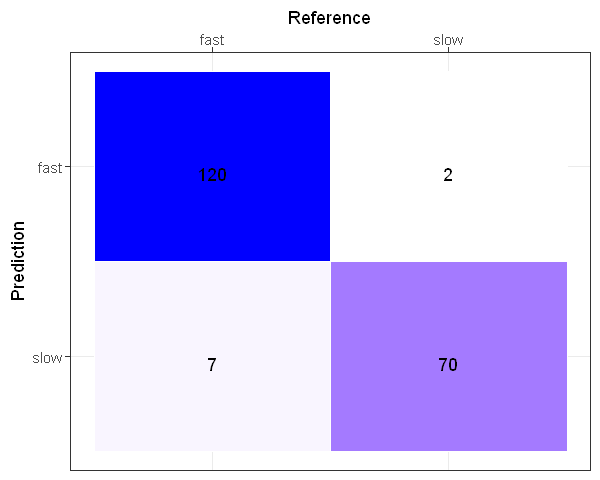

In [11]:
output <- predict(xgb_fit,data.matrix(meshdf[,1:2]))
dim(output) <- c(2,nrow(meshdf))
output<-t(output)
colnames(output) <- c('fast','slow')
pred<-colnames(output)[max.col(output, ties.method = 'first')]
meshdf$Prediction <- pred

meshdf$col <- ifelse(meshdf$Prediction == 'fast', 'blue', 'white')

p <- ggplot(meshdf) +
 geom_rect(mapping = aes(xmin=Grade-h/2, xmax=Grade+h/2, ymin=Bumpiness-h/2, ymax=Bumpiness+h/2),fill = meshdf$col) + 
 coord_fixed()
p + geom_point(aes(Grade,Bumpiness,col=Speed),data=test)

output <- predict(xgb_fit, data.matrix(test[,1:2]))
dim(output) <- c(2,nrow(test))
output<-t(output)
colnames(output) <- c('fast','slow')
pred<-colnames(output)[max.col(output, ties.method = 'first')]

cm<-confusionMatrix(pred,test$Speed)
print(cm$table)

Reference <- factor(c('fast', 'fast', 'slow', 'slow'))
Prediction <- factor(c('fast', 'slow', 'fast', 'slow'),levels=rev(levels(test$Speed)))
df <- data.frame(Reference, Prediction, Y=c(cm$table))

ggplot(data =  df, mapping = aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  theme_bw() + theme(legend.position = "none") + scale_x_discrete(position = "top")

print(paste("Accuracy:",cm$overall["Accuracy"]))

So we get a decent performance on this dataset with the XGBoost algorithm. 

## In-class Activity

We can also use decision trees to model continuous data for regressions. I want you to look up the documentation for how to do that and implement the regressions on the same data we used in Class 06. 

## Assignment

Your assignment this week is to try using the decision tree models on your own data. Record how long it took to train the models and how well they performed compared to our previous classifier/regression models.